# Confocal Scan - Random Testing and Hyper DAQ

This notebook demonstrates how to use the CounterAndScanner class (also called NiDaqPiezoScanner)
to generate a 2D image of a sample. This uses an actuator to move the location of 
laser light impinging on a sample and an NiDAQ to count the photons emitted (via 
digital TTL pulses generated from a photon detector) from the sample. When used with 
an appropriate pinhole that restricts the in-focus depth of field, 
the image is known as a confocal scan. 

In this example, dummy objects are used to demonstrate how to run without hardware, 
which is useful for testing purposes. 

More importantly, usage of a 'hyper data acquisition' function is also demonstrated. 
The hyper data acquisition function allows an experimenter to take extra data at 
each position of 2D image, such as with a spectrometer to generate a "hyperspectral image". 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import matplotlib.pyplot as plt

In [3]:
import nipiezojenapy
import qt3utils.datagenerators as datasources
import qt3utils.datagenerators.piezoscanner

In [4]:
#logging.basicConfig(level = logging.INFO) #set to logging.WARNING to suppress logged information to cells
#qt3utils.datagenerators.piezoscanner.logger.setLevel(logging.INFO)

## Object Instantiation

To generate a 2D image, three objects are used:

  * an object to control the position of the light
  * an object to count the number of photons that reach our photon detector
  * an object that uses both the position controller and photon counter to generate the image. 
  
  
In the QT3 lab, we  use the nipiezojenapy software package to control the 
piezo actuator that positions the objective over a sample and the NIDAQ 
card to count the number of TTL pulses from an SPCM. 

In this instance, for our demonstration purposes, we will use dummy 
position control and DAQ objects, which mimic usage of real hardware objects.

  * nipiezojenapy.BaseControl - dummy actuator controller
  * datasources.RandomRateCounter - random data generator
  * CounterAndScanner - perform the scans and generates the image

See the [confocal_scan](confocal-scan.ipynb) notebook for example usage of real hardware.

In [5]:
position_controller = nipiezojenapy.BaseControl()
data_acq = datasources.RandomRateCounter(simulate_single_light_source=True, num_data_samples_per_batch=50)
scanner = datasources.CounterAndScanner(data_acq, position_controller)

In [6]:
scanner.set_scan_range(0, 20, 0, 20)

In [7]:
scanner.get_current_position()

{'x': 0, 'y': 0, 'z': 0}

In [8]:
# assume we wish to generate an image at some particular depth, z

some_optimal_z = 15 
position_controller.go_to_position(z = some_optimal_z)

In [9]:
position_controller.get_current_position()

[0, 0, 15]

### Run Scan

The docstring for the `run_scan` function describes the actions it performs. 


In [10]:
help(scanner.run_scan)

Help on method run_scan in module qt3utils.datagenerators.piezoscanner:

run_scan(reset_starting_position=True, line_scan_callback=None) method of qt3utils.datagenerators.piezoscanner.CounterAndScanner instance
    Runs a scan across the range of set parameters: xmin, xmax, ymin, ymax, with increments of step_size.
    
    To get the data after the scan, call get_raw_counts() or get_count_rate(). You may also
    provide a callback function that will be called after each line scan is completed.
    
    :param reset_starting_position: if True, the actuator will be reset to the starting position before the scan begins
    :param line_scan_callback: a function that will be called after each line scan is completed. The function
                                 should take a single argument, which will be an instance of this class.
                                 i.e. line_scan_callback(obj: CounterAndScanner)
    :return: None



In [11]:
scanner.run_scan() # user logger to display text during scan

In [12]:
count_rate = scanner.get_count_rate()

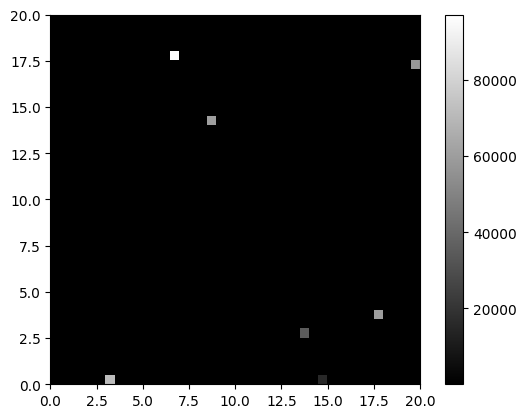

In [13]:
fig, ax = plt.subplots()
artist = ax.imshow(count_rate, cmap='gray', extent = scanner.get_completed_scan_range())
fig.colorbar(artist, ax=ax)

# Now, we add a Hyper DAQ function

A "Hyper DAQ" function allows a researcher to take data at each position 
during a scan. For example, one may wish to measure the energy spectrum
of photons at each postion, creating a hyperspectral image of a sample. 


In [14]:
import numpy as np

my_functions_data = []

def my_function(scanner_object):
    rand_data = np.random.random(100)
    my_functions_data.append([scanner_object.get_current_position(), rand_data])
    

# Since this function does not touch any hardware
# used by the scanner, we can provide the attribute 'in_parallel' = True. 
# With this setting, the scanner will run this function in a separate processing thread
# while it simultaneously acquires data from the RandomRateCounter

# In real life, one can set the hyper DAQ function to 'in_parallel' if
# the function doesn't need to touch hardware used by the confocal scan
# For example, if a beamsplitter diverts light from a sample so that both
# a spectrometer and a photon counter receive signal, a spectrum and total
# count rate can be simultaneously generated.

my_function.in_parallel = True

In [15]:
scanner.set_hyper_data_acquisition_function(my_function)

In [16]:
scanner.run_scan()
count_rate = scanner.get_count_rate()

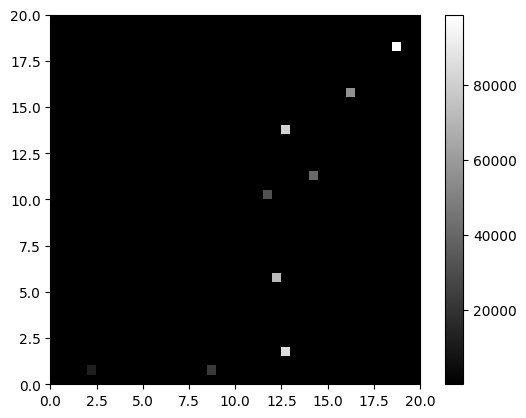

In [17]:
fig, ax = plt.subplots()
artist = ax.imshow(count_rate, cmap='gray', extent = scanner.get_completed_scan_range())
fig.colorbar(artist, ax=ax)

In [18]:
# During the scan, data was generated and stored into our array
print(len(my_functions_data))
my_functions_data[:2] #display the first two sets of data

1600


[[{'x': 0.0, 'y': 0, 'z': 15},
  array([0.31452213, 0.35451581, 0.98887843, 0.72970574, 0.09544869,
         0.27399608, 0.50155377, 0.62806833, 0.47108881, 0.95060407,
         0.6806713 , 0.23337498, 0.4045021 , 0.3622902 , 0.41479225,
         0.5255417 , 0.87803697, 0.6299015 , 0.6965338 , 0.74122237,
         0.71905561, 0.21392037, 0.05950756, 0.36841156, 0.49753285,
         0.47952426, 0.6349023 , 0.82112918, 0.2256583 , 0.71479503,
         0.66250976, 0.72881137, 0.60264403, 0.56977916, 0.22136641,
         0.64898267, 0.469511  , 0.7731227 , 0.60596433, 0.03316667,
         0.03802478, 0.24201959, 0.07425821, 0.8163585 , 0.39698327,
         0.89983163, 0.36804661, 0.30183733, 0.03262771, 0.22796159,
         0.65103523, 0.01511088, 0.11394079, 0.6507492 , 0.33257084,
         0.76230229, 0.28549521, 0.04028606, 0.36139356, 0.889166  ,
         0.67783701, 0.17723507, 0.66518609, 0.86413806, 0.69168639,
         0.79187832, 0.91038901, 0.37228708, 0.48048336, 0.06371737,
   

In [19]:
# One could imagine extending the callback to an unlimited number of functions
# (Although, care should be taken to manage memory usage)

other_data = []
shape, scale = 2., 2. # mean=4, std=2*sqrt(2)

def my_other_function(scanner):
    s = np.random.gamma(shape, scale, 1000)
    other_data.append([scanner.get_current_position(), s])
    

def both_hyper_functions(scanner):
    my_function(scanner)
    my_other_function(scanner)
    
both_hyper_functions.in_parallel = True

In [20]:
scanner.set_hyper_data_acquisition_function(both_hyper_functions)

In [21]:
scanner.run_scan()

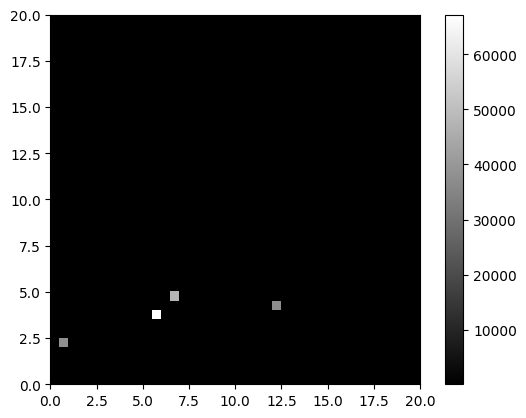

In [22]:
fig, ax = plt.subplots()
artist = ax.imshow(scanner.get_count_rate(), cmap='gray', extent = scanner.get_completed_scan_range())
fig.colorbar(artist, ax=ax)

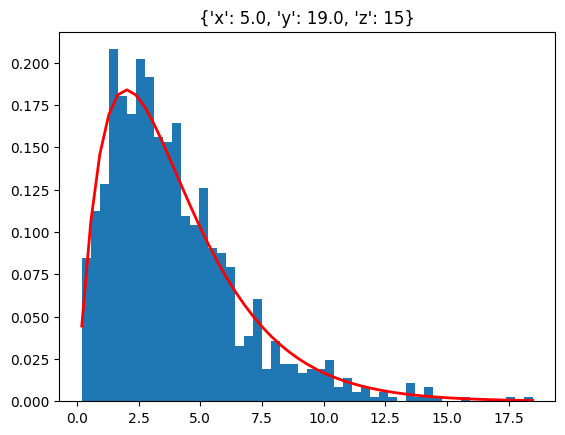

In [23]:
import matplotlib.pyplot as plt
import scipy.special as sps

#randomly choose one of elements from other_data

position, s = other_data[ np.random.choice(np.arange(len(other_data))) ]

count, bins, ignored = plt.hist(s, 50, density=True)
y = bins**(shape-1)*(np.exp(-bins/scale) /
                     (sps.gamma(shape)*scale**shape))
plt.plot(bins, y, linewidth=2, color='r')
plt.title(position)
plt.show()